Copyright 2020 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [2]:
# Install required library

# Using tfp-nightly due to https://github.com/tensorflow/probability/issues/1752
!pip install rlds tf_agents dm-reverb[tensorflow] apache_beam tfp-nightly

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 37.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 332.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 323.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 360.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 288.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 368.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [33]:
# Download zipped checkpoint folder
#install gloud, run this line in terminal
#!gcloud storage cp -r gs://gdm-robotics-open-x-embodiment/open_x_embodiment_and_rt_x_oss/rt_1_x_tf_trained_for_002272480_step.zip .

3993.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


/bin/bash: gcloud: command not found


In [34]:
# Unzip zipped checkpoint folder

#!unzip rt_1_x_tf_trained_for_002272480_step.zip

4066.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Archive:  rt_1_x_tf_trained_for_002272480_step.zip
   creating: rt_1_x_tf_trained_for_002272480_step/
  inflating: rt_1_x_tf_trained_for_002272480_step/ckpt-2272480.data-00000-of-00001  
  inflating: rt_1_x_tf_trained_for_002272480_step/fingerprint.pb  
  inflating: rt_1_x_tf_trained_for_002272480_step/policy_specs.pbtxt  
  inflating: rt_1_x_tf_trained_for_002272480_step/checkpoint  
  inflating: rt_1_x_tf_trained_for_002272480_step/ckpt-2272480.index  
  inflating: rt_1_x_tf_trained_for_002272480_step/saved_model.pb  
   creating: rt_1_x_tf_trained_for_002272480_step/variables/
  inflating: rt_1_x_tf_trained_for_002272480_step/variables/variables.data-00000-of-00001  
  inflating: rt_1_x_tf_trained_for_002272480_step/variables/variables.index  
   creating: rt_1_x_tf_trained_for_002272480_step/assets/
  inflating: rt_1_x_tf_trained_for_002272480_step/assets/metadata.textproto  


In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import rlds
from PIL import Image
import numpy as np
from tf_agents.policies import py_tf_eager_policy
import tf_agents
from tf_agents.trajectories import time_step as ts
from IPython import display
from collections import defaultdict
import matplotlib.pyplot as plt
import tensorflow_hub as hub


def as_gif(images):
  # Render the images as the gif:
  images[0].save('/tmp/temp.gif', save_all=True, append_images=images[1:], duration=1000, loop=0)
  gif_bytes = open('/tmp/temp.gif','rb').read()
  return gif_bytes


In [9]:
# Load TF model checkpoint
# Replace saved_model_path with path to the parent folder of
# the folder rt_1_x_tf_trained_for_002272480_step.
saved_model_path = '/home/user/Downloads/openxembodiment/Training/rt_1_x_tf_trained_for_002272480_step'

tfa_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    model_path=saved_model_path,
    load_specs_from_pbtxt=True,
    use_tf_function=True)

2024-08-06 09:56:12.547307: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 09:56:13.108105: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# Perform one step of inference using dummy input

# Obtain a dummy observation, where the features are all 0
observation = tf_agents.specs.zero_spec_nest(tf_agents.specs.from_spec(tfa_policy.time_step_spec.observation))

# Construct a tf_agents time_step from the dummy observation
tfa_time_step = ts.transition(observation, reward=np.zeros((), dtype=np.float32))

# Initialize the state of the policy
policy_state = tfa_policy.get_initial_state(batch_size=1)

# Run inference using the policy
action = tfa_policy.action(tfa_time_step, policy_state)

In [13]:
# Create a dataset object to obtain episode from

builder = tfds.builder_from_directory(builder_dir='/home/user/tensorflow_datasets/sarc__ur5e/1.0.0')
ds = builder.as_dataset(split='train[:1]')

ds_iterator = iter(ds)

In [14]:
for example in ds.take(1):
    print(example)


{'episode_metadata': {'file_path': <tf.Tensor: shape=(), dtype=string, numpy=b'/home/user/rlds_dataset_builder/sarc_ur5e/data/traj156/standard_output.pkl'>}, 'steps': <_VariantDataset element_spec={'action': {'gripper_closedness_action': TensorSpec(shape=(), dtype=tf.float32, name=None), 'rotation_delta': TensorSpec(shape=(3,), dtype=tf.float32, name=None), 'terminate_episode': TensorSpec(shape=(), dtype=tf.float32, name=None), 'world_vector': TensorSpec(shape=(3,), dtype=tf.float32, name=None)}, 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': {'hand_image': TensorSpec(shape=(720, 1280, 3), dtype=tf.uint8, name=None), 'image': TensorSpec(shape=(720, 1280, 3), dtype=tf.uint8, name=None), 'natural_language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'natura

In [15]:
# Obtain the steps from one episode from the dataset

episode = next(ds_iterator)
steps = episode[rlds.STEPS]


In [2]:
'''
images = []

for step in steps:

  im = Image.fromarray(np.array(step['observation']['image']))
  images.append(im)

print(f'{len(images)} images')

display.Image(as_gif(images))
'''

"\nimages = []\n\nfor step in steps:\n\n  im = Image.fromarray(np.array(step['observation']['image']))\n  images.append(im)\n\nprint(f'{len(images)} images')\n\ndisplay.Image(as_gif(images))\n"

In [17]:
def resize(image):
  image = tf.image.resize_with_pad(image, target_width=320, target_height=256)
  image = tf.cast(image, tf.uint8)
  return image

def terminate_bool_to_act(terminate_episode: tf.Tensor) -> tf.Tensor:
  return tf.cond(
      terminate_episode == tf.constant(1.0),
      lambda: tf.constant([1, 0, 0], dtype=tf.int32),
      lambda: tf.constant([0, 1, 0], dtype=tf.int32),
  )

'''
def rescale_action_with_bound(
    actions: tf.Tensor,
    low: float,
    high: float,
    safety_margin: float = 0,
    post_scaling_max: float = 1.0,
    post_scaling_min: float = -1.0,
) -> tf.Tensor:
  """Formula taken from https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range."""
  resc_actions = (actions - low) / (high - low) * (
      post_scaling_max - post_scaling_min
  ) + post_scaling_min
  return tf.clip_by_value(
      resc_actions,
      post_scaling_min + safety_margin,
      post_scaling_max - safety_margin,
  )

def rescale_action(action):
  """Rescales action."""

  action['world_vector'] = rescale_action_with_bound(
      action['world_vector'],
      low=-0.05,
      high=0.05,
      safety_margin=0.01,
      post_scaling_max=1.75,
      post_scaling_min=-1.75,
  )
  action['rotation_delta'] = rescale_action_with_bound(
      action['rotation_delta'],
      low=-0.25,
      high=0.25,
      safety_margin=0.01,
      post_scaling_max=1.4,
      post_scaling_min=-1.4,
  )

  return action

def to_model_action(from_step):
  """Convert dataset action to model action. This function is specific for the Bridge dataset."""

  model_action = {}

  model_action['world_vector'] = from_step['action']['world_vector']
  model_action['terminate_episode'] = terminate_bool_to_act(
      from_step['action']['terminate_episode']
  )

  model_action['rotation_delta'] = from_step['action']['rotation_delta']

  open_gripper = from_step['action']['open_gripper']

  possible_values = tf.constant([True, False], dtype=tf.bool)
  eq = tf.equal(possible_values, open_gripper)

  assert_op = tf.Assert(tf.reduce_any(eq), [open_gripper])

  with tf.control_dependencies([assert_op]):
    model_action['gripper_closedness_action'] = tf.cond(
        # for open_gripper in bridge dataset,
        # 0 is fully closed and 1 is fully open
        open_gripper,
        # for Fractal data,
        # gripper_closedness_action = -1 means opening the gripper and
        # gripper_closedness_action = 1 means closing the gripper.
        lambda: tf.constant([-1.0], dtype=tf.float32),
        lambda: tf.constant([1.0], dtype=tf.float32),
    )

  model_action = rescale_action(model_action)

  return model_action
  '''

def to_model_action(from_step):
  """Maps Berkeley Autolab UR5 action to action expected by the model."""

  # The world vector as existed in the dataset on disk ranges from -0.02 to 0.02
  # We scale by 100.0 so that the action spans the limit of the world_vector
  # action, from -2.0 to 2.0.
  model_action = {}

  model_action['world_vector'] = (
      from_step[rlds.ACTION]['world_vector'] * 100.0
  )
  
  
  model_action['terminate_episode'] = terminate_bool_to_act(
      from_step['action']['terminate_episode']
    )
  # Similarly, the rotation_delta in the dataset on disk ranges from -0.07 to
  # 0.07
  # We scale by 15.0 so that the rotation_delta almost spans the limit of
  # rotation_delta, from -pi/2 to pi/2.
  model_action['rotation_delta'] = (
      from_step[rlds.ACTION]['rotation_delta']*15
  )
  model_action['gripper_closedness_action'] = tf.expand_dims(
      from_step[rlds.ACTION]['gripper_closedness_action'], axis=0
  )

  return model_action




In [18]:
steps = list(steps)


In [19]:
# Load language model and

embed = hub.load(
    'https://tfhub.dev/google/universal-sentence-encoder-large/5')

In [20]:
# embed the task string

episode_natural_language_instruction = steps[0][rlds.OBSERVATION]['natural_language_instruction'].numpy().decode()

def normalize_task_name(task_name):

  replaced = task_name.replace('_', ' ').replace('1f', ' ').replace(
      '4f', ' ').replace('-', ' ').replace('50',
                                           ' ').replace('55',
                                                        ' ').replace('56', ' ')
  return replaced.lstrip(' ').rstrip(' ')


natural_language_embedding = embed([normalize_task_name(episode_natural_language_instruction)])[0]

In [21]:
# %%time

policy_state = tfa_policy.get_initial_state(batch_size=1)

gt_actions = []
predicted_actions = []
images = []

for step in steps:

  image = resize(step[rlds.OBSERVATION]['image'])

  images.append(image)
  observation['image'] = image

  tfa_time_step = ts.transition(observation, reward=np.zeros((), dtype=np.float32))

  policy_step = tfa_policy.action(tfa_time_step, policy_state)
  action = policy_step.action
  policy_state = policy_step.state

  predicted_actions.append(action)
  gt_actions.append(to_model_action(step))

In [22]:
action_name_to_values_over_time = defaultdict(list)
predicted_action_name_to_values_over_time = defaultdict(list)
figure_layout = ['terminate_episode_0', 'terminate_episode_1',
        'terminate_episode_2', 'world_vector_0', 'world_vector_1',
        'world_vector_2', 'rotation_delta_0', 'rotation_delta_1',
        'rotation_delta_2', 'gripper_closedness_action_0']
action_order = ['terminate_episode', 'world_vector', 'rotation_delta', 'gripper_closedness_action']

for i, action in enumerate(gt_actions):

  for action_name in action_order:

    for action_sub_dimension in range(action[action_name].shape[0]):

      # print(action_name, action_sub_dimension)
      title = f'{action_name}_{action_sub_dimension}'

      action_name_to_values_over_time[title].append(action[action_name][action_sub_dimension])
      predicted_action_name_to_values_over_time[title].append(predicted_actions[i][action_name][action_sub_dimension])

In [23]:
figure_layout = [
    ['image'] * len(figure_layout),
    figure_layout
]


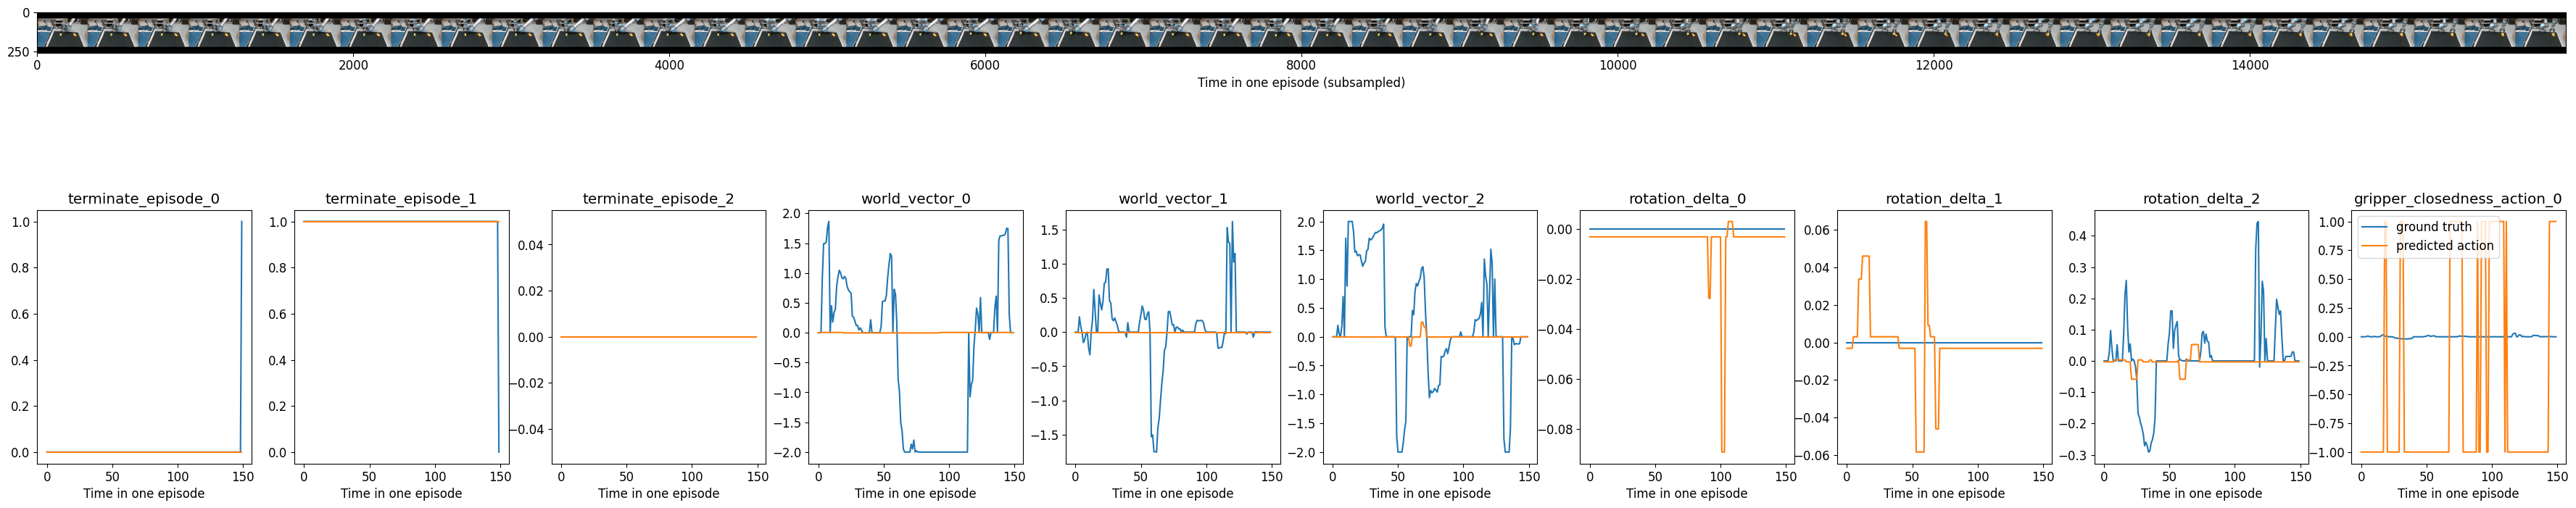

In [24]:
plt.rcParams.update({'font.size': 12})

stacked = tf.concat(tf.unstack(images[::3], axis=0), 1)

fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

for i, (k, v) in enumerate(action_name_to_values_over_time.items()):

  axs[k].plot(v, label='ground truth')
  axs[k].plot(predicted_action_name_to_values_over_time[k], label='predicted action')
  axs[k].set_title(k)
  axs[k].set_xlabel('Time in one episode')

axs['image'].imshow(stacked.numpy())
axs['image'].set_xlabel('Time in one episode (subsampled)')

plt.legend()


In [23]:
def custom_print(actions):
    import re
    actions_str = str(actions)
    # Insert a newline after each occurrence of '>}'
    formatted_str = re.sub(r'>}', '>}\n', actions_str)
    print(formatted_str)

custom_print(gt_actions)

[{'world_vector': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.22857143,  0.6857143 ,  0.35428572], dtype=float32)>, 'terminate_episode': <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 1, 0], dtype=int32)>, 'rotation_delta': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.00571429,  0.        ,  0.00857143], dtype=float32)>, 'gripper_closedness_action': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>}
, {'world_vector': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.95428574,  1.1485715 ,  0.5085714 ], dtype=float32)>, 'terminate_episode': <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 1, 0], dtype=int32)>, 'rotation_delta': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.01714286,  0.        ,  0.23714285], dtype=float32)>, 'gripper_closedness_action': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>}
, {'world_vector': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.1085714,  1.0571429